#### Author: Madhusudhanan Balasubramanian (MB), Ph.D., The University of Memphis

In [ ]:
#To estimate the Mask RCNN model performance / metrics on validation and test datasets

#Final result:
# Epoch 3 - Best model with an average F1 score of 87.49% on validation dataset and 89.43% on test dataset
# ./logs/coco20230416T2151/mask_rcnn_coco_0003.h5

#Initialization
# Root directory of the project
ROOT_DIR = "./Mask_RCNN"; #os.path.abspath("../../")
# Path for folder containing trained models
m_dir = "./logs/"
m_sdir = "coco20230416T2151"

#Model file
#model_file = "axon_model_v3_e0045.h5"
# Data directory
COCO_DIR = "./DataFiles/Phase3"
#Validation directory
validation_dir = "Phase3_Testing" #"1903_val_rev2"  #"1903_val_rev_1" #"dataset_train"

import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
from sklearn import metrics

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
#
from keras.preprocessing.image import img_to_array
#
import axon_coco as coco #copied samples/coco/coco.py as axon_coco.py

#Initialize
model_path = os.path.join(m_dir, m_sdir)
config = coco.Config()

def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    fig, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    fig.tight_layout()
    return ax

#Calculating mean Average Recal (mAR)
def compute_ar(pred_boxes, gt_boxes, list_iou_thresholds):
    AR = []
    for iou_threshold in list_iou_thresholds:
        try:
            recall, _ = utils.compute_recall(pred_boxes, gt_boxes, iou=iou_threshold)
            AR.append(recall)
        except:
            AR.append(0.0)
            pass
        
    AUC = 2 * (metrics.auc(list_iou_thresholds, AR))
    return AUC

def evaluate_model(dataset, model, cfg, list_iou_thresholds=None):
    
    debug_flag = 1;
    
    if list_iou_thresholds is None: 
        list_iou_thresholds = np.arange(0.5, 1.01, 0.1)

    APs = []
    ARs = []
    for image_id in dataset.image_ids:
        original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
        
        #MB note: it appears mold_image normalizes the image (subtract dataset mean)
        #         img_to_array(image) is used in test_axon_model_v1.ipynb
        #         This needs to be verified:
        #           detect() molds all input images in a format for feeding to the network
        #           So, no need to mold before calling detect
        #           expand_dims adds a new axis to represent multiple images fed to the network for detection
        #           np.expand_dims(image, 0) is same as [image]--the latter is a list with single entry
        #scaled_image = modellib.mold_image(image, cfg)
        #image_array = np.expand_dims(scaled_image, 0)
        image_array = img_to_array(original_image)
        
        #Detect objects in the image
        result = model.detect([image_array])[0]
        #
        boxes = result["rois"]
        masks = result["masks"]
        class_ids = result["class_ids"]
        class_names = dataset_test.class_names
        scores = result["scores"]

        if debug_flag == 1:
            print(f"No. of masks: {masks.shape[2]}")
            visualize.display_instances(image_array, boxes, masks, class_ids, 
                            class_names, scores,
                            figsize=(8,8),
                            show_mask=False, show_bbox=True, colors=None)
        
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask, 
                       boxes, class_ids, scores, masks, 
                       iou_threshold=0.5)
        #print(f"\t\t AP: {AP}; precision: {precisions}; recall: {recalls}; overlaps: {overlaps}")
        #print(f"boxes: {boxes}; gt_bbox: {gt_bbox}; list_iou_thresholds: {list_iou_thresholds}")
        AR = compute_ar(boxes, gt_bbox, list_iou_thresholds)
        ARs.append(AR)
        APs.append(AP)

    mAP = np.mean(APs)
    mAR = np.mean(ARs)
    f1_score = 2 * ((mAP * mAR) / (mAP + mAR))

    return mAP, mAR, f1_score

def multiclass_eval_metrics(class_id, gt_class_ids, pred_class_ids, gt_match, iou_threshold):
    
    verbose_result = 0;
    
    gt_positives = np.sum(gt_class_ids == class_id) #TP + FN
    ind = (gt_class_ids == class_id) #gt and pred match for the given class
    pred_match = gt_match[ind]
    pred_true_positives = np.sum(pred_match != -1) #TP
    pred_total_positives = np.sum(pred_class_ids == class_id) #TP + FP
    
    precision = pred_true_positives / pred_total_positives
    recall = pred_true_positives / gt_positives
    f1_score = 2.0 * precision * recall / (precision + recall)
    
    if verbose_result == 1:
        print(f"\t\tClass: {class_id}; TP: {pred_true_positives}; TP+FP: {pred_total_positives}; TP+FN: {gt_positives}")
        #print(f"Precision: {c1_pred_true_positives/c1_pred_total_positives}; recall: {c1_pred_true_positives / c1_gt_positives}")
    
    return precision, recall, f1_score

def evaluate_multiclass_metrics(dataset, model, cfg, iou_thresh=None):
    
    debug_flag = 0;
    verbose_result = 1;
    
    if iou_thresh is None:
        iou_thresh = 0.5
    
    #Initialize
    c1_precision_vec = []
    c1_recall_vec = []
    c1_f1_vec = []
    #
    c2_precision_vec = []
    c2_recall_vec = []
    c2_f1_vec = []
    
    for image_id in dataset.image_ids[:-1]:
        #print(f"image_id:{image_id}; path:{dataset.image_info[image_id]['path']}")
        original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
        
        #April 13, 2023: This is sorted out with the Phase3 annotation/data (reinstalled the server with necrotic id-1
        #and live id=2; also, images acquired after confocal realignment-possibly higher resolution; also, ON sections
        #with more healthy axons were included in Phase3)
        #Jan 7, 2013: Made a serious mistake in COCO annotator; first created live category and then created
        #necrotic category.  So in COCO annotator, live has a category id of 1 and necrotic has a category id
        # of 2.  But the previous models were trained with json exports from another coco annotator where the
        #categories were in reverse order.  We will flip the gt_class_id after reading to match with the 
        #previous model output where necrotic is 1 and live is 2
        #ind_cat1 = (gt_class_id == 1)
        #ind_cat2 = (gt_class_id == 2)
        #gt_class_id[ind_cat1] = 2
        #gt_class_id[ind_cat2] = 1
        
        #MB note: it appears mold_image normalizes the image (subtract dataset mean)
        #         img_to_array(image) is used in test_axon_model_v1.ipynb
        #         This needs to be verified:
        #           detect() molds all input images in a format for feeding to the network
        #           So, no need to mold before calling detect
        #           expand_dims adds a new axis to represent multiple images fed to the network for detection
        #           np.expand_dims(image, 0) is same as [image]--the latter is a list with single entry
        #scaled_image = modellib.mold_image(image, cfg)
        #image_array = np.expand_dims(scaled_image, 0)
        image_array = img_to_array(original_image)
        
        #Detect objects in the image
        result = model.detect([image_array])[0]
        #
        pred_boxes = result["rois"]
        pred_masks = result["masks"]
        pred_class_ids = result["class_ids"]
        class_names = dataset.class_names
        pred_scores = result["scores"]

        #print(f"gt_class_id:{gt_class_id}; pred_class_ids:{pred_class_ids}")
        if debug_flag == 1:
            print(f"No. of masks: {pred_masks.shape[2]}")
            visualize.display_instances(image_array, pred_boxes, pred_masks, pred_class_ids, 
                            class_names, pred_scores,
                            figsize=(8,8),
                            show_mask=True, show_bbox=False, colors=None)
            
            visualize.display_differences(original_image,
                                          gt_bbox, gt_class_id, gt_mask,
                                          pred_boxes, pred_class_ids, pred_scores, pred_masks,
                                          dataset.class_names, ax=get_ax(),
                                          show_box=False, show_mask=False,
                                          iou_threshold=0.5, score_threshold=0.5)
        
        gt_match, pred_match, overlaps = utils.compute_matches(gt_bbox, gt_class_id, gt_mask,
                                                         pred_boxes, pred_class_ids, pred_scores, pred_masks)
        
        
        class_id = 1
        c1_precision, c1_recall, c1_f1_score = multiclass_eval_metrics(class_id, gt_class_id, pred_class_ids, 
                                                              gt_match, iou_threshold)
        if verbose_result == 1:
            print(f"image_id: {image_id}; IoU threshold: {iou_thresh}")
            print(f"\t class: {class_id}; precision: {c1_precision}; recall: {c1_recall}; f1_score: {c1_f1_score}")
        class_id = 2
        c2_precision, c2_recall, c2_f1_score = multiclass_eval_metrics(class_id, gt_class_id, pred_class_ids, 
                                                              gt_match, iou_threshold)
        if verbose_result == 1:
            print(f"\t class: {class_id}; precision: {c2_precision}; recall: {c2_recall}; f1_score: {c2_f1_score}")
    
        #Store
        c1_precision_vec.append(c1_precision)
        c1_recall_vec.append(c1_recall)
        c1_f1_vec.append(c1_f1_score)
        #
        c2_precision_vec.append(c2_precision)
        c2_recall_vec.append(c2_recall)
        c2_f1_vec.append(c2_f1_score)

    c1_mean_precision = np.mean(c1_precision_vec)
    c1_mean_recall = np.mean(c1_recall_vec)
    c1_f1_score = np.mean(c1_f1_vec)
    #
    c2_mean_precision = np.mean(c2_precision_vec)
    c2_mean_recall = np.mean(c2_recall_vec)
    c2_f1_score = np.mean(c2_f1_vec)
    
    print(f"\n Mean c1_precision: {c1_mean_precision}; mean c1_recall: {c1_mean_recall}; c1_f1_score: {c1_f1_score}")
    print(f"Mean c2_precision: {c2_mean_precision}; mean c2_recall: {c2_mean_recall}; c2_f1_score: {c2_f1_score}")
    
    mean_precision = (c1_mean_precision + c2_mean_precision) / 2.0
    mean_recall = (c1_mean_recall + c2_mean_recall) / 2.0
    mean_f1_score = (c1_f1_score + c2_f1_score) / 2.0
    
    return mean_precision, mean_recall, mean_f1_score

#Model configuration for inference
class InferenceConfig(coco.CocoConfig):
    #Dec 09, 2021 MB notes: Initially, no other configuration changes needed for training (recall / see that
    # configuration changes required for inferences such as setting # GPUs to 1, etc. See axon_coco.py for 
    # other possible configuration changes
    
    #General model parameters
    BACKBONE = 'resnet50' #default is resnet101
    USE_MINI_MASK=True
    MEAN_PIXEL = [123.7, 116.8, 103.9]
        
    #General training parameters
    #----------------
    IMAGES_PER_GPU = 1 #should be 1 for inference
    GPU_COUNT = 1
    BATCH_SIZE = IMAGES_PER_GPU * GPU_COUNT #BATCH_SIZE calculated only in config.py's constructor in line 216
    #
    STEPS_PER_EPOCH = 3 #Jan 07: reduced from 100 to 75; May 10, 2022: steps/epoch = #training images/batch size
    VALIDATION_STEPS = 3 #originally 5, previously set at 15
    #
    GRADIENT_CLIP_NORM = 10.0
    LEARNING_MOMENTUM = 0.9
    WEIGHT_DECAY=0.0001
    LOSS_WEIGHTS = { "rpn_class_loss": 1., "rpn_bbox_loss": 1., "mrcnn_class_loss": 1., "mrcnn_bbox_loss": 1., "mrcnn_mask_loss": 1. }

    #RPN parameters
    #---------------
    # Length of square anchor side in pixels
    #RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128) #Was used in V11 which generated the model e608
    #RPN_ANCHOR_SCALES = (4, 8, 16, 32, 64) #Incorrectly set this in V11_Phase2 - that's why the model had issues
    # Ratios of anchors at each cell (width/height)
    # A value of 1 represents a square anchor, and 0.5 is a wide anchor
    #RPN_ANCHOR_RATIOS = [0.5, 1, 2]
    RPN_ANCHOR_RATIOS = [0.25, 0.5, 1, 2, 4]
    #References for increasing number of detections: https://github.com/matterport/Mask_RCNN/issues/1884#:~:text=What%20seems%20to%20have%20had%20the%20greatest%20impact%20for%20us%20were%20the%20training%20configs%3A
    RPN_TRAIN_ANCHORS_PER_IMAGE = 600 #default: 256; Number of anchors per image selected to train the RPN
    MAX_GT_INSTANCES = 600 #Number of GT instances per image kept to train the network
    
    #Proposal layer parameters (not trainable layer; just filtering)
    #-------------------------
    PRE_NMS_LIMIT = 6000 #default: ;Number of anchors with the best RPN score that are retained
    RPN_NMS_THRESHOLD = 0.7 #0.7 #default is 0.7; area overlap among candidate anchors before dropping the anchor with the lowest score; higher values increases the number of region proposals
    POST_NMS_ROIS_TRAINING = 1800 # >Training; ROIs kept after non-maximum supression in the proposal layer; default is 2000
    POST_NMS_ROIS_INFERENCE = 8000 # >Inference; ROIs kept after NMS in the proposal layer based on their RPN score
    
    #Detection target layer parameters (training only; not a trainable layer; just filtering)
    #Receives at most POST_NMS_ROIS_TRAINING number of anchors from the proposal layer
    #Anchors whose IoU > 0.5 over ground truth are selected (at most POST_NMS_ROIS_TRAINING)
    #---------------------------------
    TRAIN_ROIS_PER_IMAGE = 600 #default is 200; no. of ROIs randomly selected out of POST_NMS_ROIS_TRAINING
    ROI_POSITIVE_RATIO = 0.33 #default is 0.33; usually set as 1/#classes; i.e. 33% of TRAIN_ROIS_PER_IMAGE should be positive
       
    #Detection layer parameters (inference only; not trainable, just filtering)
    #Receives at most POST_NMS_ROIS_INFERENCE number of anchors from the proposal layer
    #MB: https://medium.com/@umdfirecoml/training-a-mask-r-cnn-model-using-the-nucleus-data-bcb5fdbc0181 
    #----------------------------
    DETECTION_MIN_CONFIDENCE = 0.7 #default: 0.7; AOIs with lower confidence than this are discarded
    DETECTION_NMS_THRESHOLD = 0.3 #reference: 0.3; AOIs those with higher overlapping areas are discarded based on their RPN score

    #Feature Pyramid Network (FPN)
    #Has a classifier and mask graph; identifies class and generates mask
    #---------------------------------
    DETECTION_MAX_INSTANCES = 600 # >Inference; maximum number of instances identified by Mask RCNN

inference_config = InferenceConfig()
inference_config.display()

#Axon annotation validation data
dataset_test = coco.CocoDataset()
dataset_test.load_coco(COCO_DIR, validation_dir)
dataset_test.prepare() # Must call before using the dataset

#Create a Mask RCNN model in "inference" mode
model = modellib.MaskRCNN(mode="inference", config=inference_config, model_dir = coco.DEFAULT_LOGS_DIR)

# Get path to saved weights
#model_abs_file = os.path.join(model_path, model_file)


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        600
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             10.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

Using TensorFlow backend.




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


# Evaluate multiclass performance metrics

Model file: /home/madhu/Lab/Members/00_madhu/Programs/axon_segmentation/logs/coco20230416T2151/mask_rcnn_coco_0003.h5






Re-starting from epoch 3
image_id: 0; IoU threshold: 0.5
	 class: 1; precision: 0.9404761904761905; recall: 1.0; f1_score: 0.9693251533742331
	 class: 2; precision: 0.8705882352941177; recall: 0.9866666666666667; f1_score: 0.925
image_id: 1; IoU threshold: 0.5
	 class: 1; precision: 0.9518072289156626; recall: 1.0; f1_score: 0.9753086419753086
	 class: 2; precision: 0.8; recall: 0.9333333333333333; f1_score: 0.8615384615384616
image_id: 2; IoU threshold: 0.5
	 class: 1; precision: 0.9308176100628931; recall: 0.8176795580110497; f1_score: 0.8705882352941178
	 class: 2; precision: 0.8333333333333334; recall: 1.0; f1_score: 0.9090909090909091
image_id: 3; IoU threshold: 0.5
	 class: 1; precision: 0.8992805755395683; recall: 0.9920634920634921; f1_score: 0.9433962264150942
	 class: 2; precision: 0.8701298701298701; recall: 0.9710144927536232; f1_score: 0.9178082191780

image_id: 2; IoU threshold: 0.5
	 class: 1; precision: 0.8922155688622755; recall: 0.8232044198895028; f1_score: 0.8563218390804598
	 class: 2; precision: 0.782608695652174; recall: 0.96; f1_score: 0.8622754491017965
image_id: 3; IoU threshold: 0.5
	 class: 1; precision: 0.8794326241134752; recall: 0.9841269841269841; f1_score: 0.9288389513108614
	 class: 2; precision: 0.868421052631579; recall: 0.9565217391304348; f1_score: 0.9103448275862069
image_id: 4; IoU threshold: 0.5
	 class: 1; precision: 0.924812030075188; recall: 0.825503355704698; f1_score: 0.8723404255319149
	 class: 2; precision: 0.908256880733945; recall: 0.9339622641509434; f1_score: 0.9209302325581395
image_id: 5; IoU threshold: 0.5
	 class: 1; precision: 0.8571428571428571; recall: 0.732824427480916; f1_score: 0.7901234567901235
	 class: 2; precision: 0.9056603773584906; recall: 0.9230769230769231; f1_score: 0.9142857142857143
image_id: 6; IoU threshold: 0.5
	 class: 1; precision: 0.9139784946236559; recall: 0.9239130

image_id: 11; IoU threshold: 0.5
	 class: 1; precision: 0.8639455782312925; recall: 0.900709219858156; f1_score: 0.8819444444444444
	 class: 2; precision: 0.8837209302325582; recall: 0.9047619047619048; f1_score: 0.8941176470588236

 Mean c1_precision: 0.869641035855484; mean c1_recall: 0.8946432934155625; c1_f1_score: 0.8797186333396243
Mean c2_precision: 0.8198440319579929; mean c2_recall: 0.9019226074400618; c2_f1_score: 0.8569974257556238
Mean_precision: 0.8447425339067385; mean_recall: 0.8982829504278121; F1 score: 0.8683580295476241
Model file: /home/madhu/Lab/Members/00_madhu/Programs/axon_segmentation/logs/coco20230416T2151/mask_rcnn_coco_0053.h5
Re-starting from epoch 53
image_id: 0; IoU threshold: 0.5
	 class: 1; precision: 0.8707865168539326; recall: 0.9810126582278481; f1_score: 0.9226190476190476
	 class: 2; precision: 0.7865168539325843; recall: 0.9333333333333333; f1_score: 0.853658536585366
image_id: 1; IoU threshold: 0.5
	 class: 1; precision: 0.8494623655913979; recal

image_id: 6; IoU threshold: 0.5
	 class: 1; precision: 0.8380952380952381; recall: 0.9565217391304348; f1_score: 0.8934010152284265
	 class: 2; precision: 0.75; recall: 0.8048780487804879; f1_score: 0.7764705882352942
image_id: 7; IoU threshold: 0.5
	 class: 1; precision: 0.8176100628930818; recall: 0.9558823529411765; f1_score: 0.8813559322033899
	 class: 2; precision: 0.7671232876712328; recall: 0.8484848484848485; f1_score: 0.8057553956834531
image_id: 8; IoU threshold: 0.5
	 class: 1; precision: 0.7853881278538812; recall: 0.9197860962566845; f1_score: 0.8472906403940886
	 class: 2; precision: 0.8396946564885496; recall: 0.8661417322834646; f1_score: 0.8527131782945735
image_id: 9; IoU threshold: 0.5
	 class: 1; precision: 0.7795698924731183; recall: 0.9177215189873418; f1_score: 0.8430232558139534
	 class: 2; precision: 0.7482993197278912; recall: 0.8943089430894309; f1_score: 0.8148148148148148
image_id: 10; IoU threshold: 0.5
	 class: 1; precision: 0.9032258064516129; recall: 0.

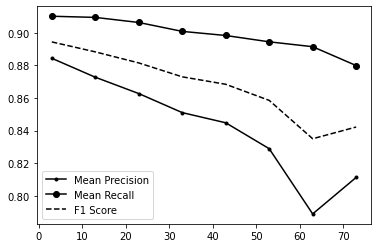

In [2]:
import os, re
#file_regex = "^\w+0*(608|628|[8-9]\d{2}|1\d{3})\.h5$"
#file_regex = "^\w+0*(608|1173)\.h5$"
#file_regex = "^\w+0*(608)\.h5$"
file_regex = "^\w+0*([003])\.h5$"
#model_num_list = list(range(608, 710))
#model_num_list = [608, 1173]
#model_num_list = [608]
#model_num_list.extend(list(range(1170, 1200)))
model_num_list = []

iou_threshold = 0.5
plot_precision_threshold = 0.01

mean_precision_list = []
mean_recall_list = []
f1_list = []
files = sorted(os.listdir(model_path))
for file in files:
    if re.match(file_regex, file):
        model_num = int(file[15:19])
        model_num_list.append(model_num)

        model_abs_file = os.path.join(model_path, file)
        print(f"Model file: {model_abs_file}")
        model.load_weights(model_abs_file, by_name=True)

        #Estimate model performance metrics
        mean_precision, mean_recall, F1_score = evaluate_multiclass_metrics(dataset_test, model, inference_config,
                                                                           iou_threshold)
        mean_precision_list.append(mean_precision)
        mean_recall_list.append(mean_recall)
        f1_list.append(F1_score)
        print(f"Mean_precision: {mean_precision}; mean_recall: {mean_recall}; F1 score: {F1_score}")
        
print(f"RPN_NMS_THRESHOLD: {inference_config.RPN_NMS_THRESHOLD}")
print(f"DETECTION_MIN_CONFIDENCE: {inference_config.DETECTION_MIN_CONFIDENCE}")
print(f"DETECTION_NMS_THRESHOLD: {inference_config.DETECTION_NMS_THRESHOLD}")
print(f"DETECTION_MAX_INSTANCES: {inference_config.DETECTION_MAX_INSTANCES}")

#Plot the results
model_arr = np.array(model_num_list)
mean_precision_arr = np.array(mean_precision_list)
mean_recall_arr = np.array(mean_recall_list)
f1_arr = np.array(f1_list)

ind_sel = mean_precision_arr >= plot_precision_threshold
model_sel_arr = model_arr[ind_sel]
mean_precision_sel_arr = mean_precision_arr[ind_sel]
mean_recall_sel_arr = mean_recall_arr[ind_sel]
f1_sel_arr = f1_arr[ind_sel]

plt.plot(model_sel_arr, mean_precision_sel_arr, 'k.-', label='Mean Precision')
plt.plot(model_sel_arr, mean_recall_sel_arr, 'ko-', label='Mean Recall')
plt.plot(model_sel_arr, f1_sel_arr, 'k--', label='F1 Score')
plt.legend()
plt.show()